<a href="https://colab.research.google.com/github/leonardoLavagna/PyTorch-Notebooks/blob/main/Notebook_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Notebook 3
In this Notebook we will familiarize with the standard PyTorch workflow, that is a standard deep learning pipeline. The standard PyTorch workflow can be summarized in the following steps:


1.   Get the data (i.e. tensors);
2.   Build or pick a model;
3.   Fit the model to the data and make inference
4.   Evaluate the model
5.   Improve by experimentation
6.   Save and reuse/adapt the trained model

In the followin example of PyThorch workflow we will focus on the first three points, by trying to predict a simple straight line. The same three steps we will see here can be adapted, in principle, to solve any other deep learning problem.

In [ ]:
import torch
from torch import nn

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


**Remark .** The module `nn` contains all the basic functionalities of neural networks, see https://pytorch.org/docs/stable/nn.html.

In [ ]:
import matplotlib.pyplot as plt

## Get the data
We'll use linear regression to create the data with known parameters, and then we'll use PyTorch to see if we can build model to estimate these parameters using gradient descent.

In [ ]:
# Create known parameters
weight = 0.6
bias = 0.4

# Create data
start = 0
end = 1
step = 0.01
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

len(X), len(y)

(100, 100)

## Build or pick a model
Now we're going to move towards building a model that can learn the relationship between X (features) and y (labels). Before we build a model we need to split it up. One of most important steps in a machine learning project is creating a training and test set (and when required, a validation set). Each split of the dataset serves a specific purpose:


*   **Training set** the model learns from this data (~70% of the data);
*   **Testing set**	the model gets evaluated on this data to test what it has learned (~30% of the data);
*   **Validation set (optional)**	the model gets tuned on this data.

PyTorch has four essential modules you can use to create almost any kind of neural network you can imagine. They are `torch.nn`, `torch.optim`, `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`. For now, we'll focus on the first two.

In [ ]:
# Create train/test split
train_split = int(0.7 * len(X)) 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(70, 70, 30, 30)

The model we create is going to try and learn the relationship between `X_train` & `y_train` and then we will evaluate what it learns on `X_test` and `y_test`.

In [ ]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

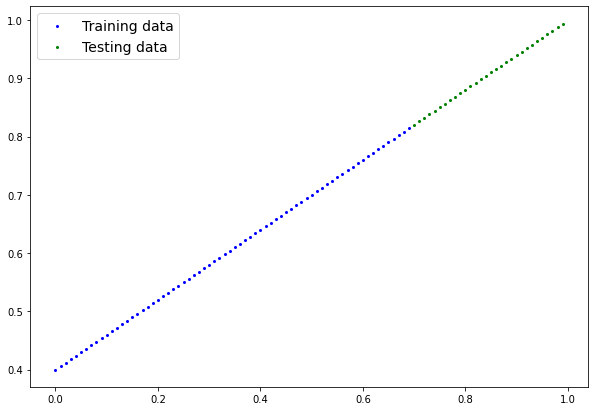

In [ ]:
plot_predictions();

**Remark .** We'll be using Python classes to create bits and pieces for building neural networks. If you're unfamiliar with Python class notation, see https://realpython.com/python3-object-oriented-programming.

In [ ]:
# Create a Linear Regression model class
# Note: almost everything in PyTorch is a nn.Module
class LinearRegressionModel(nn.Module): 
    def __init__(self):
        super().__init__() 
        # Start with random weights (this will get adjusted as the model learns)
        self.weights = nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float))

        self.bias = nn.Parameter(torch.randn(1,requires_grad=True, dtype=torch.float ))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

In [ ]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# List named parameters 
model.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Fit the model to the data and make inference
We start by fitting our model to the data

In [ ]:
# Make predictions with model
with torch.inference_mode(): 
    y_preds = model(X_test)

In [ ]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 30
Number of predictions made: 30
Predicted values:
tensor([[0.3645],
        [0.3679],
        [0.3712],
        [0.3746],
        [0.3780],
        [0.3813],
        [0.3847],
        [0.3881],
        [0.3914],
        [0.3948],
        [0.3982],
        [0.4015],
        [0.4049],
        [0.4083],
        [0.4116],
        [0.4150],
        [0.4184],
        [0.4217],
        [0.4251],
        [0.4285],
        [0.4318],
        [0.4352],
        [0.4386],
        [0.4419],
        [0.4453],
        [0.4487],
        [0.4520],
        [0.4554],
        [0.4588],
        [0.4621]])


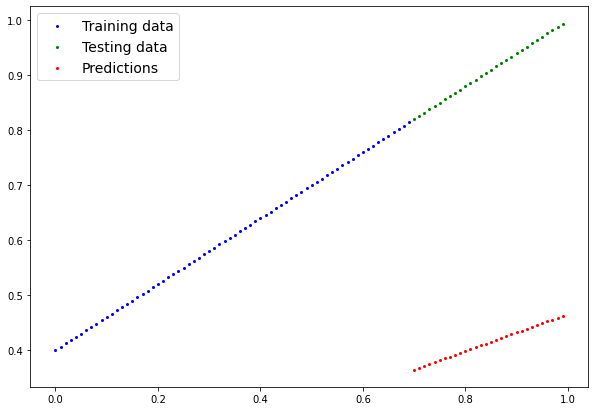

In [ ]:
plot_predictions(predictions=y_preds)

**Remark .** Those predictions look pretty bad... This make sense since our model is just using random parameter values to make predictions. It hasn't even looked at the blue dots to try to predict the green dots...

For our model to update its parameters on its own, we'll need to add a few more things to our recipe. That's  

*   a **loss function**: Measures how wrong your models predictions (e.g. y_preds) are compared to the truth labels (e.g. y_test). Lower the better;
*   as well as an **optimizer**: Tells your model how to update its internal parameters to best lower the loss.

In [ ]:
# Create the loss function
loss_fn = nn.L1Loss() 

# Create the optimizer
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.01) 

Now we've got a loss function and an optimizer, it's now time to create a **training loop** and **testing loop**. The training loop involves the model going through the training data and learning the relationships between the features and labels. The testing loop involves going through the testing data and evaluating how good the patterns are that the model learned on the training data (the model never see's the testing data during training). 

### Training loop
*   **Forward pass**: The model goes through all of the training data once, performing its `forward()` function calculations.
*   **Calculate the loss**: The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.	
*   **Zero gradients**: The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step.		
*   **Perform backpropagation on the loss**: Computes the gradient of the loss with respect for every model parameter to be updated.
*   **Update the optimizer (gradient descent)**: Update the parameters with  respect to the loss gradients in order to improve them.

### Testing Loop
*   **Forward pass**: The model goes through all of the training data once, performing its `forward()` function calculations.
*   **Calculate the loss**: The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.	
*   **Calulate evaluation metrics (optional)**: Alongisde the loss value you may want to calculate other evaluation metrics such as accuracy on the test set.	

In [ ]:
torch.manual_seed(1234)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    #TRAINING

    # Put model in training mode 
    model.train()

    # Forward pass 
    y_pred = model(X_train)

    #Calculate the loss 
    loss = loss_fn(y_pred, y_train)

    # Zero gradients of the optimizer
    optimizer.zero_grad()

    # Backwards pass
    loss.backward()

    # Progress the optimizer
    optimizer.step()

    #TESTING

    # Put the model in evaluation mode
    model.eval()

    with torch.inference_mode():
      # Forward pass 
      test_pred = model(X_test)

      # Caculate loss 
      # predictions come in torch.float datatype, so comparisons need to be  done with tensors of the same type 
      test_loss = loss_fn(test_pred, y_test.type(torch.float))  

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.362032413482666 | MAE Test Loss: 0.4807719886302948 
Epoch: 10 | MAE Train Loss: 0.2501298487186432 | MAE Test Loss: 0.3516193628311157 
Epoch: 20 | MAE Train Loss: 0.13822737336158752 | MAE Test Loss: 0.22246691584587097 
Epoch: 30 | MAE Train Loss: 0.036716021597385406 | MAE Test Loss: 0.10287977755069733 
Epoch: 40 | MAE Train Loss: 0.023810159415006638 | MAE Test Loss: 0.06668094545602798 
Epoch: 50 | MAE Train Loss: 0.021008959040045738 | MAE Test Loss: 0.05708857253193855 
Epoch: 60 | MAE Train Loss: 0.01828880049288273 | MAE Test Loss: 0.049729641526937485 
Epoch: 70 | MAE Train Loss: 0.015569031238555908 | MAE Test Loss: 0.04199790954589844 
Epoch: 80 | MAE Train Loss: 0.012848825193941593 | MAE Test Loss: 0.034638721495866776 
Epoch: 90 | MAE Train Loss: 0.010128621011972427 | MAE Test Loss: 0.02727953903377056 


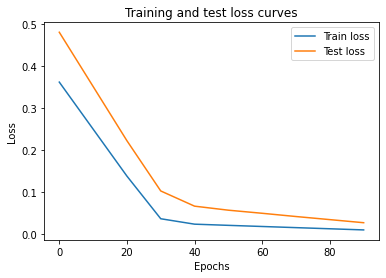

In [ ]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [ ]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.5578])), ('bias', tensor([0.4154]))])

And the original values for weights and bias are:
weights: 0.6, bias: 0.4


Now we will make inference (predictions). We've already seen a glimpse of this in the training and testing code above, the steps to do it outside of the training/testing loop are similar.

In [ ]:
# Set the model in evaluation mode
model.eval()

# Setup the inference mode context manager
with torch.inference_mode():
  # Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model.to(device)
  # X_test = X_test.to(device)
  y_preds = model(X_test)

print(y_preds)

tensor([[0.8058],
        [0.8114],
        [0.8170],
        [0.8226],
        [0.8281],
        [0.8337],
        [0.8393],
        [0.8449],
        [0.8505],
        [0.8560],
        [0.8616],
        [0.8672],
        [0.8728],
        [0.8783],
        [0.8839],
        [0.8895],
        [0.8951],
        [0.9007],
        [0.9062],
        [0.9118],
        [0.9174],
        [0.9230],
        [0.9286],
        [0.9341],
        [0.9397],
        [0.9453],
        [0.9509],
        [0.9564],
        [0.9620],
        [0.9676]])


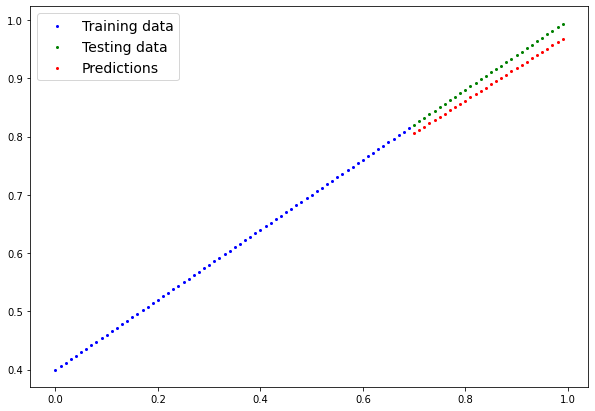

In [ ]:
plot_predictions(predictions=y_preds)


## Saving and reusing a PyTorch model


In [ ]:
from pathlib import Path

# Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path 
MODEL_NAME = "Model_in_Notebook_3.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),f=MODEL_SAVE_PATH) 

Saving model to: models/Model_in_Notebook_3.pth


In [ ]:
# Check the saved file path
#!ls -l models/Model_in_Notebook_3.pth

In [ ]:
# Reuse the previously saved model
# Instantiate a new instance of our model
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model 
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
# Put the loaded model into evaluation mode
loaded_model_0.eval()

# Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

In [ ]:
# Compare previous model predictions with loaded model predictions 
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## Exercises


1.   Create a traight line dataset with `weight=0.1` and `baias=0.9` with at least 100 data points. Then split the data into 80% training and 20% testing, plot the training and testing data. Once you have the data, create a PyThorch model as described above and define a loss function (e.g. `nn.L1Loss()`) and an optimizer (e.g. `torch.optim.SGD()`). Write the training loop to perform appropriate training steps for 100 epochs. Make predictions with the trained model and save the results to file.


